In [1]:
from __future__ import print_function

#Exploring Topics in Data Science

##Probability mass functions

###1: Introduction to the data

In this lesson, we'll be working with data from the <a href= "http://www.cdc.gov/nchs/nsfg.htm">National Survey of Family Growth</a>. The data was collected from January 2002 to March 2003. It contains data on pregnancy, family life, and more. We'll use it to explore various correlations.

We've selected a few columns from the original data, which are:
- prglngth -- the length of the pregnancy in weeks.
- birthord -- which child this was for the pregnant mother.
- birthwgt_lb1 -- the pounds portion of the birth weight.
- birthwgt_oz1 -- the ounces portion of the birth weight.
- agepreg -- the mother's age at the end of the pregnancy, in years.

This lesson is based on Chapter 3 of <a href = "http://www.thinkstats2.com/">Think Stats, 2nd edition, by Allen Downey</a>.

####Instructions

Find the mean agepreg for mothers in firsts. Assign the result to mean_firsts_agepreg.

Find the mean agepreg for mothers in others. Assign the result to mean_others_agepreg.

In [2]:
# %load nsfg
"""This file contains code for use with "Think Stats",
by Allen B. Downey, available from greenteapress.com

Copyright 2010 Allen B. Downey
License: GNU GPLv3 http://www.gnu.org/licenses/gpl.html
"""

from collections import defaultdict
import numpy as np
import pandas
import re
import sys


def ReadStataDct(dct_file, **options):
    """Reads a Stata dictionary file.

    dct_file: string filename
    options: dict of options passed to open()

    returns: FixedWidthVariables object
    """
    type_map = dict(byte=int, int=int, long=int, float=float, double=float)

    var_info = []
    for line in open(dct_file, **options):
        match = re.search( r'_column\(([^)]*)\)', line)
        if match:
            start = int(match.group(1))
            t = line.split()
            vtype, name, fstring = t[1:4]
            name = name.lower()
            if vtype.startswith('str'):
                vtype = str
            else:
                vtype = type_map[vtype]
            long_desc = ' '.join(t[4:]).strip('"')
            var_info.append((start, vtype, name, fstring, long_desc))
            
    columns = ['start', 'type', 'name', 'fstring', 'desc']
    variables = pandas.DataFrame(var_info, columns=columns)

    # fill in the end column by shifting the start column
    variables['end'] = variables.start.shift(-1)
    variables.loc[len(variables)-1, 'end'] = 0

    dct = FixedWidthVariables(variables, index_base=1)
    return dct


class FixedWidthVariables(object):
    """Represents a set of variables in a fixed width file."""

    def __init__(self, variables, index_base=0):
        """Initializes.

        variables: DataFrame
        index_base: are the indices 0 or 1 based?

        Attributes:
        colspecs: list of (start, end) index tuples
        names: list of string variable names
        """
        self.variables = variables

        # note: by default, subtract 1 from colspecs
        self.colspecs = variables[['start', 'end']] - index_base

        # convert colspecs to a list of pair of int
        self.colspecs = self.colspecs.astype(np.int).values.tolist()
        self.names = variables['name']

    def ReadFixedWidth(self, filename, **options):
        """Reads a fixed width ASCII file.

        filename: string filename

        returns: DataFrame
        """
        df = pandas.read_fwf(filename,
                             colspecs=self.colspecs, 
                             names=self.names,
                             **options)
        return df

    
def ReadFemPreg(dct_file='data/2002FemPreg.dct',
                dat_file='data/2002FemPreg.dat.gz'):
    """Reads the NSFG pregnancy data.

    dct_file: string file name
    dat_file: string file name

    returns: DataFrame
    """
    dct = ReadStataDct(dct_file)
    df = dct.ReadFixedWidth(dat_file, compression='gzip')
    CleanFemPreg(df)
    return df


def CleanFemPreg(df):
    """Recodes variables from the pregnancy frame.

    df: DataFrame
    """
    # mother's age is encoded in centiyears; convert to years
    df.agepreg /= 100.0

    # birthwgt_lb contains at least one bogus value (51 lbs)
    # replace with NaN
    df.birthwgt_lb[df.birthwgt_lb > 20] = np.nan
    
    # replace 'not ascertained', 'refused', 'don't know' with NaN
    na_vals = [97, 98, 99]
    df.birthwgt_lb.replace(na_vals, np.nan, inplace=True)
    df.birthwgt_oz.replace(na_vals, np.nan, inplace=True)
    df.hpagelb.replace(na_vals, np.nan, inplace=True)

    df.babysex.replace([7, 9], np.nan, inplace=True)
    df.nbrnaliv.replace([9], np.nan, inplace=True)

    # birthweight is stored in two columns, lbs and oz.
    # convert to a single column in lb
    # NOTE: creating a new column requires dictionary syntax,
    # not attribute assignment (like df.totalwgt_lb)
    df['totalwgt_lb'] = df.birthwgt_lb + df.birthwgt_oz / 16.0    

    # due to a bug in ReadStataDct, the last variable gets clipped;
    # so for now set it to NaN
    df.cmintvw = np.nan


def MakePregMap(df):
    """Make a map from caseid to list of preg indices.

    df: DataFrame

    returns: dict that maps from caseid to list of indices into preg df
    """
    d = defaultdict(list)
    for index, caseid in df.caseid.iteritems():
        d[caseid].append(index)
    return d


def main(script):
    """Tests the functions in this module.

    script: string script name
    """
    df = ReadFemPreg()
    print(df.shape)

    assert len(df) == 13593

    assert df.caseid[13592] == 12571
    assert df.pregordr.value_counts()[1] == 5033
    assert df.nbrnaliv.value_counts()[1] == 8981
    assert df.babysex.value_counts()[1] == 4641
    assert df.birthwgt_lb.value_counts()[7] == 3049
    assert df.birthwgt_oz.value_counts()[0] == 1037
    assert df.prglngth.value_counts()[39] == 4744
    assert df.outcome.value_counts()[1] == 9148
    assert df.birthord.value_counts()[1] == 4413
    assert df.agepreg.value_counts()[22.75] == 100
    assert df.totalwgt_lb.value_counts()[7.5] == 302

    weights = df.finalwgt.value_counts()
    key = max(weights.keys())
    assert df.finalwgt.value_counts()[key] == 6

    print('%s: All tests passed.' % script)

#if __name__ == '__main__':
#    main(*sys.argv)

In [3]:
 preg = ReadFemPreg()
#list(preg.columns.values)

births = preg[['prglngth', 'birthord', 'birthwgt_lb', 'birthwgt_oz', 'agepreg']]
#print("births:", births)

# There are large differences between the first pregnancy and subsequent onces, so let's split the data up.
firsts = births[births["birthord"] == 1]
others = births[births["birthord"] > 1]

# We end up with around 7000 rows for each.
print("others.shape:", others.shape)
print("firsts.shape:", firsts.shape)

mean_firsts_agepreg = firsts["agepreg"].mean()
mean_others_agepreg = others["agepreg"].mean()

others.shape: (4735, 5)
firsts.shape: (4413, 5)


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


###2: What's a PMF?

A <a href = "http://en.wikipedia.org/wiki/Probability_mass_function">probability mass function</a> is a function that maps from a discrete rabdom variable to the probability of each value occuring. In the case of our dataset, a discrete random variable is just a column.

Before we generate a probability mass function, we generate a histogram, which just contains counts of each unique value occuring.

####Instructions

Extend the Pmf class to generate probabilities instead of counts. Once easy way to achieve this is to divide the count of each unique item by the total number of items. All the probabilities should sum to 1.

Assign the dictionary containing the probability of each unique value occuring in the column prglngth in firsts to prglngth_firsts_pmf.

In [4]:
# Let's make a histogram class that counts up all the unique values in a column.
from collections import Counter

class Hist(object):
    def __init__(self, column):
        counts = Counter(column)
        self.counts = dict(counts)

# We can use the class to count up the unique values in prglngth.
prglngth_firsts_hist = Hist(firsts["prglngth"])
print("prglngth_firsts_hist.counts:", prglngth_firsts_hist.counts)

class Pmf(Hist):
    def __init__(self, column):
        counts = Counter(column)
        self.counts = dict(counts)
        total = float(len(column))
        for c in self.counts:
            self.counts[c] /= total

prglngth_firsts_pmf = Pmf(firsts["prglngth"]).counts
print("prglngth_firsts_pmf:", prglngth_firsts_pmf)

prglngth_firsts_hist.counts: {0: 1, 17: 1, 20: 1, 21: 1, 22: 3, 23: 1, 24: 7, 25: 1, 26: 16, 27: 1, 28: 24, 29: 9, 30: 73, 31: 15, 32: 55, 33: 28, 34: 29, 35: 159, 36: 172, 37: 208, 38: 272, 39: 2114, 40: 536, 41: 360, 42: 205, 43: 87, 44: 23, 45: 6, 46: 1, 47: 1, 48: 3}
prglngth_firsts_pmf: {0: 0.00022660321776569228, 17: 0.00022660321776569228, 20: 0.00022660321776569228, 21: 0.00022660321776569228, 22: 0.0006798096532970768, 23: 0.00022660321776569228, 24: 0.0015862225243598459, 25: 0.00022660321776569228, 26: 0.0036256514842510764, 27: 0.00022660321776569228, 28: 0.005438477226376614, 29: 0.0020394289598912306, 30: 0.016542034896895538, 31: 0.003399048266485384, 32: 0.012463176977113076, 33: 0.0063448900974393836, 34: 0.006571493315205076, 35: 0.03602991162474507, 36: 0.03897575345569907, 37: 0.04713346929526399, 38: 0.0616360752322683, 39: 0.47903920235667347, 40: 0.12145932472241106, 41: 0.08157715839564922, 42: 0.04645365964196692, 43: 0.01971447994561523, 44: 0.0052118740086109

###3: Plotting a pmf

We can plot a pmf to see the probability distribution. This can be done with matplotlib.

####Instructions

prglngth_firsts_pmf and prglngth_others_pmf are both dictionaries containing the probabilities of each value in their respective dataset and column pairs occuring. prglngth_firsts_pmf contains probabilities for prglngth in the firsts dataset.

Plot both pmfs as basic bar charts, using the template plt.bar(x, y). Be sure to use plt.show() after plotting each pmf. Also be sure to sort the dictionary keys from lowest to highest before you plot.

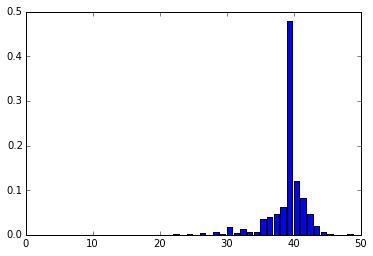

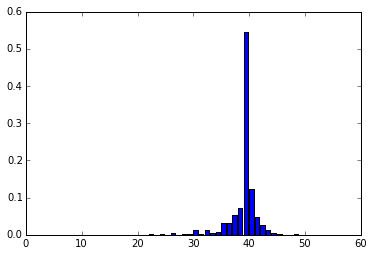

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

prglngth_others_pmf = Pmf(others["prglngth"]).counts

def get_plot_data(pmf):
    keys = sorted(pmf.keys())
    y = [pmf[k] for k in keys]
    return keys, y

firsts_pmf = get_plot_data(prglngth_firsts_pmf)
others_pmf = get_plot_data(prglngth_others_pmf)

plt.bar(firsts_pmf[0], firsts_pmf[1])
plt.show()

plt.bar(others_pmf[0], others_pmf[1])
plt.show()

###4: Finding differences between PMFs

We can also find the difference between 2 PMFs. This is as simple as subtracting the probabilities of each value occuring for one from the other. It is made slightly complicated by dealing with values that only occur in one, but not the other.

####Instructions

Make a list of all the keys that occur in prglngth_firsts_pmf and prglngth_others_pmf. These keys should be unique (each value in the list should only occur once). Sort this list in ascending order. Assign this to prglngth_all_keys.

For each key in prglngth_all_keys, find the corresponding probability in prglngth_firsts_pmf (probability is 0 if key not found) and subtract the corresponding probability in prglngth_others_pmf. Make a list with all the results, called prglngth_prob_diffs.

Make a basic bar plot with prglngth_all_keys on the x axis, and prglngth_prob_diffs on the y axis.

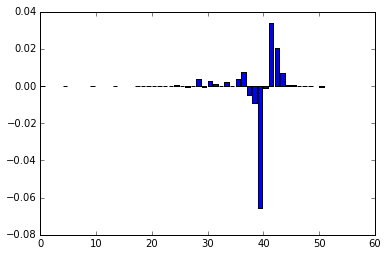

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

combined_keys = list(prglngth_firsts_pmf.keys()) + list(prglngth_others_pmf.keys())
unique_keys = list(set(combined_keys))
all_keys = sorted(unique_keys)
prglngth_prob_diffs = [prglngth_firsts_pmf.get(k, 0) - prglngth_others_pmf.get(k, 0) for k in all_keys]

plt.bar(all_keys, prglngth_prob_diffs)
plt.show()